In [1]:
import silence_tensorflow.auto
import tensorflow as tf
gpuDevices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpuDevices))
tf.config.experimental.set_memory_growth(gpuDevices[0], True)
tf.config.optimizer.set_experimental_options({'layout_optimizer': False})
import keras
import os, sys, random, glob, time, logging, io,math
from PIL import Image

from IPython import display
import matplotlib.pyplot as plt
import numpy as np

I0000 00:00:1725987389.383298   33680 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725987389.421648   33680 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725987389.424392   33680 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


Num GPUs Available:  1


In [15]:
batch_size = 32
image_shape = (40,160,1)
code_length = 4
lr=0.01
charset_length = 10
shuff_size =20000

In [3]:
def get_shape(ds:tf.data.Dataset):
    for image, label in ds.unbatch().take(1):
        tf.print("image:")
        tf.print(tf.shape(image))
        tf.print(image.dtype)
        tf.print("label:")
        tf.print(tf.shape(label))
        tf.print(label.dtype)
        # print("Single label:", label.numpy())

def decode_one_hot(one_hot_label: tf.Tensor) ->  tf.Tensor:
    one_hot_reshaped = tf.reshape(one_hot_label, [code_length, charset_length])
    digits = tf.argmax(one_hot_reshaped, axis=-1)
    return tf.strings.reduce_join(tf.strings.as_string(digits), axis=0)
    

def decode_one_hot_2dim(one_hot_label : tf.Tensor) ->  tf.Tensor:
    one_hot_reshaped = tf.reshape(one_hot_label, [code_length, charset_length])
    return tf.argmax(one_hot_reshaped, axis=1)


def viz_ds(ds:tf.data.Dataset, count=6):
    plt.figure()
    ds= ds.unbatch().take(count)
    dsit = iter(ds)
    for i in range(count):
        image, label  = next(dsit)  # type: ignore
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image.numpy().astype("uint8"),cmap="gray")
        if (len(label.numpy().shape) == 2):
             plt.title(decode_one_hot_2dim(label).numpy())
        else:
            plt.title(label.numpy())
            
        plt.tight_layout()
        plt.axis("off")

In [4]:
def get_label(file_path: tf.Tensor):
  parts = tf.strings.split(file_path, os.path.sep)
  return tf.strings.split(parts[-1], ".")[0]

In [5]:
def label_to_one_hot_2d(label:tf.Tensor) -> tf.Tensor:
    digits = tf.strings.to_number(tf.strings.unicode_split(label, 'UTF-8'), out_type=tf.int32)
    one_hot_digits = tf.one_hot(digits, depth=10)
    return one_hot_digits


# # Unit test:
# test_label = tf.constant("123456", dtype=tf.string)
# one_hot_result = label_to_one_hot_2d(test_label)
# print(one_hot_result.numpy())
# print(one_hot_result.numpy().shape)

[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
(6, 10)


I0000 00:00:1725987389.869171   33680 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725987389.872255   33680 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725987389.876069   33680 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725987390.006107   33680 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [6]:
def decode_img(img: tf.Tensor) -> tf.Tensor:
  return tf.io.decode_image(img,channels=1, dtype=tf.float32, expand_animations = False) # type: ignore

def preprocess_image(image:tf.Tensor) -> tf.Tensor:
  # tf.print(tf.shape(image))
  image = tf.image.resize(image, image_shape[:2])
  image = tf.image.per_image_standardization(image)
  return image

def preprocess_label(label : tf.Tensor) -> tf.Tensor:
  return label_to_one_hot_2d(label)

In [7]:
def configure_for_performance(ds:tf.data.Dataset) -> tf.data.Dataset:
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=shuff_size)
  ds = ds.batch(batch_size,drop_remainder=True)
  ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
  return ds

In [8]:
def process_path(file_path:tf.Tensor) -> tuple[tf.Tensor,tf.Tensor]:
  label = get_label(file_path)
  # tf.print(label)
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return preprocess_image(img), preprocess_label(label)

In [9]:
def create_dataset(folderName: str) -> tf.data.Dataset :
    ds = tf.data.Dataset.list_files(f"{folderName}/*.jpg", shuffle=False)
    
    ds = ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
    ds = configure_for_performance(ds)
    print(ds.cardinality().numpy())
    viz_ds(ds)
    return ds

786


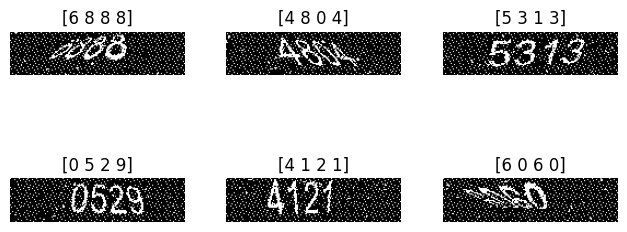

In [10]:
main_ds = create_dataset("/mnt/Data/ML/datasets/captchas-austria")
ds_size = main_ds.cardinality().numpy()
train_ds = main_ds.take(math.floor(ds_size * 0.8)) 
test_ds = main_ds.skip(math.floor(ds_size * 0.8))


In [16]:
loss_fn = keras.losses.CategoricalCrossentropy()
optimizer = keras.optimizers.Adam(learning_rate=lr)
train_loss = keras.metrics.Mean(name='train_loss')
train_acc_metric = keras.metrics.CategoricalAccuracy(name='train_accuracy')

In [18]:
def make_encoder() :
    input_layer = keras.layers.Input(shape=image_shape)
    x = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = keras.layers.MaxPooling2D((2, 2))(x)

    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = keras.layers.MaxPooling2D((2, 2))(x)

    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = keras.layers.MaxPooling2D((2, 2))(x)

    
    x = keras.layers.Flatten(name='flatten_after_convs')(x)
    x = keras.layers.Dense(768, activation='relu')(x)
    x = keras.layers.Dropout(0.5)(x)

    output_layer = keras.layers.Dense(code_length * charset_length, activation='softmax')(x)
    output_layer = keras.layers.Reshape((code_length, charset_length), name='final_reshape')(output_layer)
    model = keras.models.Model(inputs=input_layer, outputs=output_layer)
    
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    model.summary()
    
    return model
        

model = make_encoder()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 40, 160, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 40, 160, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 20, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 20, 80, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 10, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 10, 40, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 5, 20, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_after_convs (Flatten)   │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 768)            │     9,831,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 40)             │        30,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ final_reshape (Reshape)         │ (None, 4, 10)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,954,600 (37.97 MB)

 Trainable params: 9,954,600 (37.97 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
print(model.input_shape)
print(model.output_shape)
print(model.dtype)
input, target = next(iter(train_ds.take(1)))
print(input.shape)
print(target.shape)
print(target.dtype)


(None, 40, 160, 1)
(None, 4, 10)
float32
(32, 40, 160, 1)
(32, 4, 10)
<dtype: 'float32'>


In [21]:
# tf.config.run_functions_eagerly(False)
# tf.debugging.set_log_device_placement(True)
model.fit(train_ds, epochs=30)

Epoch 1/30
628/628 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9806 - loss: 0.0576
Epoch 2/30
628/628 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9812 - loss: 0.0566
Epoch 3/30
628/628 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9809 - loss: 0.0557
Epoch 4/30
628/628 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9823 - loss: 0.0525
Epoch 5/30
628/628 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9823 - loss: 0.0505
Epoch 6/30
628/628 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9813 - loss: 0.0510
Epoch 7/30
628/628 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9836 - loss: 0.0486
Epoch 8/30
628/628 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9849 - loss: 0.0458
Epoch 9/30
628/628 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9833 - loss: 0.0488
Epoch 10/30
628/628 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9852 - loss: 0.0423
Epoch 11/30
628/628 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9849 - loss: 0.0443
Epoch 12/30
628/628 ━━━━━━━━━━━━━━━━━━━━ 

In [24]:
def evaluate_model_visual(model, test_dataset:tf.data.Dataset):
    loss, accuracy = model.evaluate(test_dataset)
    
    print(f"Test Loss: {loss}")
    print(f"Test Accuracy: {accuracy}")
    for images, labels in test_dataset.take(1):
        predictions = model.predict(images)
        
        plt.figure(figsize=(12, 8))  # Adjust figure size for better display
        for i in range(len(images)):
            true_label = labels[i].numpy()
            pred_label = tf.nn.softmax(predictions[i]).numpy()
            
            # Get predicted and true label indices
            pred_label_indices = np.argmax(pred_label, axis=-1)
            true_label_indices = np.argmax(true_label, axis=-1)
            
            # Subplot with 3 images per row
            plt.subplot(len(images) // 3 + 1, 3, i + 1)
            plt.imshow(images[i].numpy().reshape(image_shape[:2]), cmap='gray')
            plt.title(f"True: {true_label_indices}, Pred: {pred_label_indices}")
            plt.axis('off')  # Hide axes for better visualization
        
        plt.tight_layout()
        plt.show()

158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9999 - loss: 6.4122e-04
Test Loss: 0.0005034488276578486
Test Accuracy: 0.9999505281448364
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


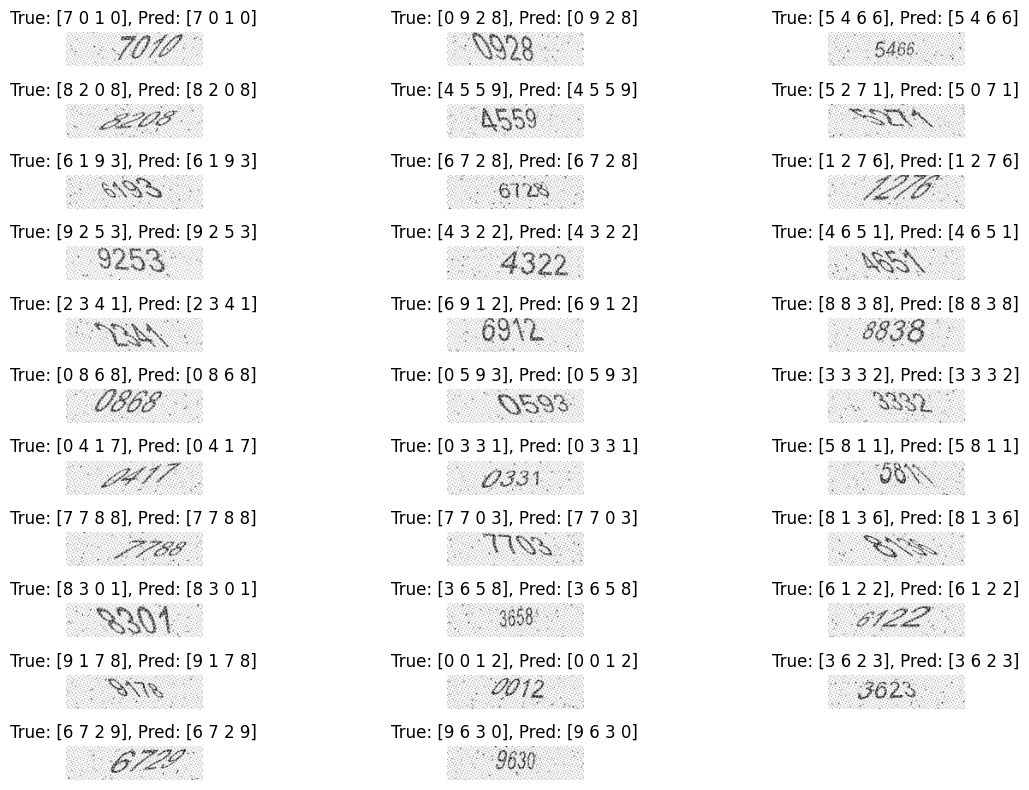

In [25]:
evaluate_model_visual(model, test_ds)

In [27]:
model.save(filepath="mame.keras")

In [ ]:
# onnx_model, _ = tf2onnx.convert.from_keras(model, input_signature, opset=13)